In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
Phi = np.array([
    [0.9697, 0.0196, 0.1776],
    [-0.0098, 0.9999, -0.0009],
    [0, 0, 0.8187]
])

Gamma = np.array([
    [0.0185, 0.1974],
    [-0.0001, 0.1390],
    [0.4148, -0.0118]
])

C = np.array([
    [1, 0, 0],
    [0, 1, 0]
])

In [85]:
class DTLTI(object):
    def __init__(self, Phi, Gamma, C=None, D=None, x0=None, v_std=None):
        self.Phi = Phi
        self.Gamma = Gamma
        self.C = C
        self.D = D
        
        self.noise_measurement_std = v_std
        
        self.x0 = x0
        self.x = self.x0
        self.k = 0
        
    @property
    def Phi(self):
        return self._Phi
    
    @Phi.setter
    def Phi(self, F):
        try:
            F.shape
        except:
            raise TypeError("Phi must be a numpy array.")
        else:
            self._Phi = F
        
    @property
    def Gamma(self):
        return self._Gamma
    
    @Gamma.setter
    def Gamma(self, G):
        try:
            G.shape
        except:
            raise TypeError("Gamma must be a numpy array.")
        else:
            if self.Phi.shape[0] != G.shape[0]:
                raise ValueError("Gamma must have the same number of rows as Phi.")
            else:
                self._Gamma = G

    @property
    def C(self):
        return self._C
    
    @C.setter
    def C(self, C):
        if C is not None:
            try:
                C.shape
            except:
                raise TypeError("C must be a numpy array.")
            else:
                if self.Phi.shape[1] != C.shape[1]:
                    raise ValueError("C must have the same number of columns as Phi.")
                else:
                    self._C = C
        else:
            C = np.eye(self.Phi.shape[1])
            self._C = C
    
    @property
    def D(self):
        return self._D
            
    @D.setter
    def D(self, D):
        if D is not None:
            try:
                D.shape
            except:
                raise TypeError("D must be a numpy array.")
            else:
                if self.Phi.shape[1] != D.shape[1]:
                    raise ValueError("D must have the same number of columns as Gamma.")
                else:
                    self._D = D
        else:
            D = np.zeros(self.Gamma.shape)
            self._D = D
            
    @property
    def x0(self):
        return self._x0
            
    @x0.setter
    def x0(self, x0):
        if x0 is not None:
            try:
                x0.shape
            except:
                raise TypeError("x0 must be a numpy array.")
            else:
                if x0.shape[0] != 1:
                    x0 = x0.reshape((x0.shape[0],1))
                else:
                    pass
                
                if self.Phi.shape[1] != x0.shape[0]:
                    raise ValueError("x0 must have the same number of rows as the columns of Phi.")
                else:
                    self.x = x0
                    self._x0 = x0
        else:
            x0 = np.zeros((self.Phi.shape[0],1))
            self.x = x0
            self._x0 = x0
            
    @property
    def x(self):
        return self._x
    
    @x.setter
    def x(self, x):
        try:
            x.shape
        except:
            raise TypeError("x must be a numpy array.")
        else:
            if x.shape[0] != 1:
                x = x.reshape((x.shape[0],1))
            else:
                pass

            if self.Phi.shape[1] != x.shape[0]:
                raise ValueError("x must have the same number of rows as the columns of Phi.")
            else:
                self._x = x
                self.y = self.C.dot(x)
                
    @property
    def y(self):
        return self._y
    
    @y.setter
    def y(self, y):
        self._y = y + self.noise_measurement
        
    @property
    def noise_measurement_std(self):
        return self._v_std
        
    @noise_measurement_std.setter
    def noise_measurement_std(self, std=None):
        if std is not None:
            try:
                list(std)
            except:
                raise TypeError("Measurement noise standard deviations must be list-like.")
            else:
                if len(std) == self.C.shape[0]:
                    self._v_std = np.asarray(std).reshape((self.C.shape[0], 1))
                else:
                    raise ValueError("Number of measurement noise standard deviations must equal number of rows in C.")
        else:
            self._v_std = np.zeros((self.C.shape[0], 1))
        
    @property
    def noise_measurement(self):
        if self._v_std is not None:
            dv = np.random.normal(0, self.noise_measurement_std)
            dv = dv.reshape((dv.shape[0], 1))
            return dv
        else:
            return np.zeros((self.C.shape[0], 1))
        
    @property
    def xbar0(self):
        return self._xbar0
    
    @xbar0.setter
    def xbar0(self, xbar0):
        self._xbar0 = xbar0
        self.xbar = xbar0
    
    @property
    def xbar(self):
        return self._xbar
    
    @xbar.setter
    def xbar(self, xbar):
        self._xbar = xbar
                
    def update_xbar(self, Phi, Gamma, u):
        self.xbar = Phi(self.k).dot(self.xhat) + Gamma(self.k).dot(u)
        
    @property
    def xhat(self):
        return self._xhat
    
    @xhat.setter
    def xhat(self, xhat):
        self._xhat = xhat
        
    def update_xhat(self, L):
        self.xhat = self.xbar + L.dot(self.y - self.C.dot(self.xbar))
            
    def step(self, u=None, xr=None, K=None, L=None, Phi=None, Gamma=None, steps=1):
        if L is not None:
            x = self.xhat
        else:
            x = self.x
            
        if xr is not None:
            try:
                xr.shape
            except:
                raise TypeError("xr must be a numpy array.")
            else:
                if xr.shape[0] != 1:
                    xr = xr.reshape((xr.shape[0],1))
                else:
                    pass
                
                if self.Phi.shape[1] != xr.shape[0]:
                    raise ValueError("xr must have the same number of rows as the columns of Phi.")
                else:
                    pass
        else:
            pass
        
        if u is not None:
            try:
                u.shape
            except:
                raise TypeError("Control input u must be a numpy array.")
            else:
                if u.shape[0] != 1:
                    u = u.reshape((u.shape[0],1))
                else:
                    pass

                if self.Gamma.shape[1] != u.shape[0]:
                    raise ValueError("x0 must have the same number of rows as the number of columns of Gamma.")
        else:
            if K is not None:
                try:
                    K.shape
                except:
                    raise TypeError("Feedback gain K must be a numpy array.")
                else:
                    if K.shape == (self.Gamma.shape[1], self.Phi.shape[1]):
                        if xr is None:
                            u = -K.dot(x)
                        else:
                            u = -K.dot(x - xr)
                    else:
                        raise ValueError(f"K.shape must have dimensions {(self.Gamma.shape[0], self.Phi.shape[1])}.")
            else:
                u = np.zeros((self.Gamma.shape[1],1))
                
        if Phi is None:
            Phi = lambda k : self.Phi
                
        if Gamma is None:
                Gamma = lambda k : self.Gamma
                
        for step in range(steps):
            self.x = Phi(self.k).dot(self.x) + Gamma(self.k).dot(u)
            
            if L is not None:
                self.update_xbar(Phi, Gamma, u)
                self.update_xhat(L)
                
            self.k += 1
            
    def LQR(self, Q1, Q2, horizon="infinite", N=50, Nwin=10, Phi=None, Gamma=None):
        if Phi is None:
                Phi = lambda k : self.Phi
                
        if Gamma is None:
            Gamma = lambda k : self.Gamma
            
        N = int(np.abs(N))
            
        try:
            Q1.shape
        except:
            raise TyeError("Weighting matrix Q1 must be a numpy array.")
        else:
            if Q1.shape != self.Phi.shape:
                raise ValueError(f"Weighting matrix Q1 must have dimensions ({self.Phi.shape})")
            else:
                try:
                    Q2.shape
                except:
                    raise TyeError("Weighting matrix Q2 must be a numpy array.")
                else:
                    if Q2.shape != (self.Gamma.shape[1], self.Gamma.shape[1]):
                        raise ValueError(f"Weighting matrix Q2 must have dimensions ({(self.Gamma.shape[1], self.Gamma.shape[1])})")
                    else:
                        pass
                                
        if horizon is "infinite":
            if np.isclose(0, np.linalg.det(Q2)):
                raise ValueError("Weighting matrix Q2 must be nonsingular.")
            elif np.isclose(0, np.linalg.det(self.Phi)):
                raise ValueError("Phi must be nonsingular.")
                
            Sinfty = scipy.linalg.solve_discrete_are(self.Phi, self.Gamma, Q1, Q2)
            Kinfty = np.linalg.inv(Q2 + self.Gamma.T.dot(Sinfty.dot(self.Gamma))).dot(self.Gamma.T.dot(Sinfty.dot(self.Phi)))
            
            K = Kinfty
            
        elif horizon is "finite":                
            S_l = [Q1]
            K_l = [np.linalg.inv(Q2+(Gamma(N).T).dot(Q1.dot(Gamma(N)))).dot((Gamma(N).T).dot(Q1.dot(Phi(N))))]
            
            for k in range(N-1,-1,-1):
                Sk1 = S_l[-1]
                R = Q2+(Gamma(k).T).dot(Sk1.dot(Gamma(k)))
                M = Sk1-Sk1.dot(Gamma(k).dot(
                            np.linalg.inv(R).dot(
                            (Gamma(k).T).dot(
                            Sk1))))
                Sk = (Phi(k).T).dot(M.dot(Phi(k))) + Q1
                Kk = np.linalg.inv(R).dot((Gamma(k).T).dot(Sk1.dot(Phi(k))))
                S_l.append(Sk)
                K_l.append(Kk)
                
            K = K_l[::-1]
            
        elif horizon in ["receding", "moving", "sliding"]:
            K_l = []
            for k in range(N):
                K_l.append(self.LQR(Q1, Q2, N=Nwin, Phi=lambda l : Phi(k+l) if k+l <= N else np.zeros(self.Phi.shape), Gamma=lambda l : Gamma(k+l) if k+l <= N else np.zeros(self.Gamma.shape), horizon="finite")[0])
            
            K = K_l
            
        return K
    
    def LQE(self, Rw, Rv, Gamma1=None, horizon="infinite", N=50, Nwin=10, Phi=None, Gamma=None, x0=None, M0=None, return_M=False):
        if Phi is None:
            Phi = lambda k : self.Phi
                
        if Gamma is None:
            Gamma = lambda k : self.Gamma
            
        if Gamma1 is None:
            Gamma1 = lambda k : self.Gamma
            
        N = int(np.abs(N))
            
        try:
            Rw.shape
        except:
            raise TyeError("Process noise covariance matrix Rw must be a numpy array.")
        else:
            if Rw.shape[0] != Gamma1(self.k).shape[1]:
                raise ValueError(f"Process noise covariance matrix Rw must have dimensions {(Gamma1(self.k).shape[1], Gamma1(self.k).shape[1])}.")
            elif Gamma1(self.k).shape[0] != self.Phi.shape[0]:
                raise ValueError(f"Process noise matrix Gamma1 must have dimensions {(self.Phi[0], Rw.shape[0])}.")
            else:
                try:
                    Rv.shape
                except:
                    raise TyeError("Measurement noise covariance matrix Rv must be a numpy array.")
                else:
                    if Rv.shape != (self.C.shape[0], self.C.shape[0]):
                        raise ValueError(f"Measurement noise covariance matrix Rv must have dimensions {(self.C.shape[0], self.C.shape[0])}.")
                    else:
                        pass
                                
        if horizon is "infinite":
            if np.isclose(0, np.linalg.det(Rv), atol=1e-12):
                raise ValueError("Measurement noise covariance matrix Rv must be nonsingular.")
            elif np.isclose(0, np.linalg.det(self.Phi), atol=1e-12):
                raise ValueError("Phi must be nonsingular.")
                
            Minfty = scipy.linalg.solve_discrete_are(self.Phi.T, self.C.T, Gamma1(self.k).dot(Rw.dot(Gamma1(self.k).T)), Rv)
            Linfty = Minfty.dot(self.C.T.dot(np.linalg.inv(self.C.dot(Minfty.dot(self.C.T)) + Rv)))            
            L = Linfty
            
        elif horizon is "finite":
            if M0 is None:
#                 M0 = 0.1*np.max(self.C)*np.ones(self.Phi.shape)
                M0 = np.diag([np.max(Rv)]*self.Phi.shape[0])
#                 expectidx = [k for k in range(self.Phi.shape[0]) if sum(C[:,k]) != 0]
#                 !FIX FOR COMPOSITE C
#                 print(expectidx)
#                 for k, idx in enumerate(expectidx):
#                     M0[idx,idx] = Rv[k,k]
            else:
                try:
                    M0.shape
                except:
                    raise TypeError("Initial predictor error covariance matrix M0 must be a numpy array.")
                else:
                    if M0.shape != self.Phi.shape:
                        raise ValueError("Initial predictor error covariance matrix M0 must have same dimensions as Phi.")
                    
            if x0 is None:
                x0 = np.zeros((self.Phi.shape[0],1))
                expectidx = [k for k in range(self.Phi.shape[0]) if sum(C[:,k]) != 0]
                
                if None in expectidx:
                    expectidx = expectidx.remove(None)
                else:
                    pass
#                 !FIX FOR COMPOSITE C
#                 for k, idx in enumerate(expectidx):
#                     x0[idx] = self.y[k]
            else:
                try:
                    x0.shape
                except:
                    raise TypeError("x0 must be a numpy array.")
                else:
                    if x0.shape[0] != 1:
                        x0 = x0.reshape((x0.shape[0],1))
                    else:
                        pass

                    if self.Phi.shape[1] != x0.shape[0]:
                        raise ValueError("x0 must have the same number of rows as the columns of Phi.")
                    else:
                        pass
                
            M_l = [M0]
            P_l = [M0 - M0.dot(self.C.T.dot(np.linalg.pinv(self.C.dot(M0.dot(self.C.T))) + Rv).dot(self.C.dot(M0)))]
            L_l = [P_l[-1].dot(self.C.T.dot(np.linalg.inv(Rv)))]
            
            for k in range(0, N):
                Mk1 = Phi(k).dot(P_l[-1].dot(Phi(k).T)) + Gamma1(k).dot(Rw.dot(Gamma1(k).T))
#                 print(self.C.dot(Mk1.dot(self.C.T)))
#                 print("Mk1", Mk1)
                Pk1 = Mk1 - Mk1.dot(self.C.T.dot(np.linalg.pinv(self.C.dot(Mk1.dot(self.C.T))) + Rv).dot(self.C.dot(Mk1)))
                Lk1 = P_l[-1].dot(self.C.T.dot(np.linalg.inv(Rv)))
                M_l.append(Mk1)
                P_l.append(Pk1)
                L_l.append(Lk1)
                
            if return_M:
                L = (L_l, M_l)
            else:
                L = L_l
            
        elif horizon in ["receding", "moving", "sliding"]:
            M_l = [None]
            L_l = []
            for k in range(N):
#                 print("Window", k)
                L, M = self.LQE(Rw, Rv, Gamma1=lambda l : Gamma1(k+l) if k+l <= N else np.zeros(self.Gamma.shape), N=Nwin, M0=M_l[-1], Phi=lambda l : Phi(k+l) if k+l <= N else np.zeros(self.Phi.shape), Gamma=lambda l : Gamma(k+l) if k+l <= N else np.zeros(self.Gamma.shape), horizon="finite", return_M=True)
                L_l.append(L[0])
                M_l.append(M[-1])
            
            L = L_l
            
        return L

In [7]:
Q1 = np.array([
    [0.25, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
])

Q2 = np.diag([0.04, 0.01])

Rv = np.diag([0.0004, 0.0001])
Rw = np.diag([0.0001, 0.0001])

In [8]:
mpl.rcParams["figure.figsize"] = 9, 5

# Linear Quadratic Feedback Loops
## Infinite Horizon
### LQR

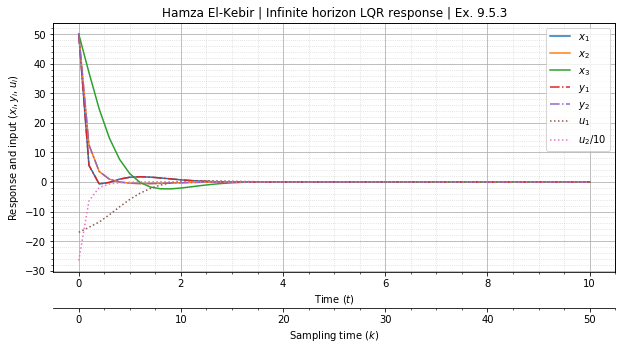

In [10]:
sysDT = DTLTI(Phi, Gamma, C)
sysDT.x0 = np.array([50,50,50])
sysDT.k = 0
x_lIH = [sysDT.x0]
y_lIH = [sysDT.y]
for k in range(50):
    sysDT.step(K=sysDT.LQR(Q1, Q2))
    x_lIH.append(sysDT.x)
    y_lIH.append(sysDT.y)

K = sysDT.LQR(Q1, Q2)
    
ax1 = plt.subplot(1,1,1)
    
ax1.plot(0.2*np.arange(0,50+0.2), [x[0] for x in x_lIH], label=r"$x_1$")
ax1.plot(0.2*np.arange(0,50+0.2), [x[1] for x in x_lIH], label=r"$x_2$")
ax1.plot(0.2*np.arange(0,50+0.2), [x[2] for x in x_lIH], label=r"$x_3$")
ax1.plot(0.2*np.arange(0,50+0.2), [y[0] for y in y_lIH], linestyle='-.', label=r"$y_1$")
ax1.plot(0.2*np.arange(0,50+0.2), [y[1] for y in y_lIH], linestyle='-.', label=r"$y_2$")
ax1.plot(0.2*np.arange(0,50+0.2), [(-K.dot(x))[0] for x in x_lIH], linestyle=':', label=r"$u_1$")
ax1.plot(0.2*np.arange(0,50+0.2), [(-K.dot(x))[1]/10 for x in x_lIH], linestyle=':', label=r"$u_2 / 10$")
ax1.set_xlabel(f"Time ($t$)")
ax1.set_ylabel(f"Response and input ($x_i, y_i, u_i$)")
ax1.minorticks_on()
ax1.grid(which='minor', alpha=0.5, linestyle=":")
ax1.grid(which='major')

plt.legend()

ax2 = ax1.twiny()
ax2.set_xticks(0.2*np.arange(0,51,10))
ax2.set_xticklabels(np.arange(0,51,10))
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 36))
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel(f"Sampling time ($k$)")
ax2.minorticks_on()
    
plt.tight_layout(2)
plt.title("Hamza El-Kebir | Infinite horizon LQR response | Ex. 9.5.3")
plt.savefig("InfHor953.pdf")

### LQG

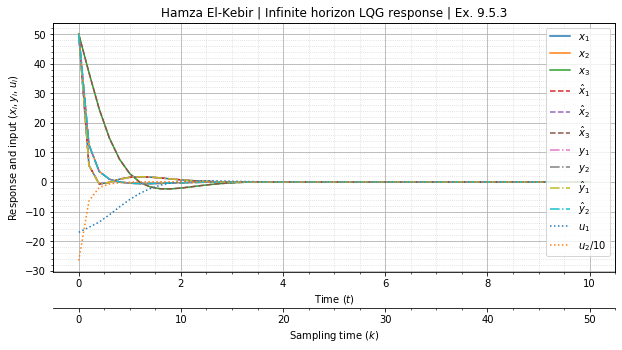

In [119]:
sysDT = DTLTI(Phi, Gamma, C, v_std=[0.02, 0.01])
sysDT.x0 = np.array([50,50,50])
sysDT.k = 0
sysDT.xbar0 = sysDT.x0
sysDT.xhat = sysDT.xbar0

x_lIH = [sysDT.x0]
x_lIH = [sysDT.x0]
xbar_lIH = [sysDT.xbar]
xhat_lIH = [sysDT.xhat]
y_lIH = [sysDT.y]

K = sysDT.LQR(Q1, Q2)
L = sysDT.LQE(Rw, Rv)

for k in range(50):
    sysDT.step(K=K, L=L)
    x_lIH.append(sysDT.x)
    xbar_lIH.append(sysDT.xbar)
    xhat_lIH.append(sysDT.xhat)
    y_lIH.append(sysDT.y)
    
ax1 = plt.subplot(1,1,1)
    
ax1.plot(0.2*np.arange(0,50+0.2), [x[0] for x in x_lIH], label=r"$x_1$")
ax1.plot(0.2*np.arange(0,50+0.2), [x[1] for x in x_lIH], label=r"$x_2$")
ax1.plot(0.2*np.arange(0,50+0.2), [x[2] for x in x_lIH], label=r"$x_3$")
ax1.plot(0.2*np.arange(0,50+0.2), [x[0] for x in xhat_lIH], linestyle='--', label=r"$\hat{x}_1$")
ax1.plot(0.2*np.arange(0,50+0.2), [x[1] for x in xhat_lIH], linestyle='--', label=r"$\hat{x}_2$")
ax1.plot(0.2*np.arange(0,50+0.2), [x[2] for x in xhat_lIH], linestyle='--', label=r"$\hat{x}_3$")
ax1.plot(0.2*np.arange(0,50+0.2), [y[0] for y in y_lIH], linestyle='-.', label=r"$y_1$")
ax1.plot(0.2*np.arange(0,50+0.2), [y[1] for y in y_lIH], linestyle='-.', label=r"$y_2$")
ax1.plot(0.2*np.arange(0,50+0.2), [y[0] for y in y_lIH], linestyle='-.', label=r"$\hat{y}_1$")
ax1.plot(0.2*np.arange(0,50+0.2), [y[1] for y in y_lIH], linestyle='-.', label=r"$\hat{y}_2$")
ax1.plot(0.2*np.arange(0,50+0.2), [(-K.dot(x))[0] for x in x_lIH], linestyle=':', label=r"$u_1$")
ax1.plot(0.2*np.arange(0,50+0.2), [(-K.dot(x))[1]/10 for x in x_lIH], linestyle=':', label=r"$u_2 / 10$")
ax1.set_xlabel(f"Time ($t$)")
ax1.set_ylabel(f"Response and input ($x_i, y_i, u_i$)")
ax1.minorticks_on()
ax1.grid(which='minor', alpha=0.5, linestyle=":")
ax1.grid(which='major')

plt.legend(loc=1)

ax2 = ax1.twiny()
ax2.set_xticks(0.2*np.arange(0,51,10))
ax2.set_xticklabels(np.arange(0,51,10))
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 36))
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel(f"Sampling time ($k$)")
ax2.minorticks_on()
    
plt.tight_layout(2)
plt.title("Hamza El-Kebir | Infinite horizon LQG response | Ex. 9.5.3")
plt.savefig("InfHor953LQG.pdf")

In [120]:
C.dot(np.linalg.inv())L

array([[ 0.13933892,  0.05549434],
       [ 0.01387358,  0.12264759],
       [ 0.05205249, -0.02338293]])

## Finite Horizon
### LQR

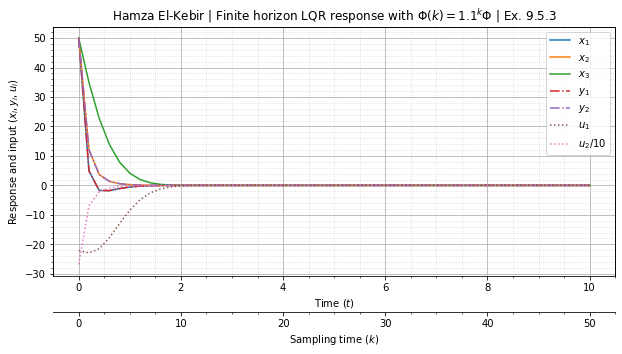

In [42]:
sysDT = DTLTI(Phi, Gamma, C)
sysDT.x0 = np.array([50,50,50])
sysDT.k = 0

Phi_fn = lambda k : (1.1**k)*Phi

K = sysDT.LQR(Q1, Q2, N=50, Phi=Phi_fn, horizon="finite")

x_lFH = [sysDT.x0]
y_lFH = [sysDT.y]
    
for k in range(50):
    sysDT.step(K=K[k], Phi=Phi_fn)
    x_lFH.append(sysDT.x)
    y_lFH.append(sysDT.y)
    
ax1 = plt.subplot(1,1,1)
    
ax1.plot(0.2*np.arange(0,50+0.2), [x[0] for x in x_lFH], label=r"$x_1$")
ax1.plot(0.2*np.arange(0,50+0.2), [x[1] for x in x_lFH], label=r"$x_2$")
ax1.plot(0.2*np.arange(0,50+0.2), [x[2] for x in x_lFH], label=r"$x_3$")
ax1.plot(0.2*np.arange(0,50+0.2), [y[0] for y in y_lFH], linestyle='-.', label=r"$y_1$")
ax1.plot(0.2*np.arange(0,50+0.2), [y[1] for y in y_lFH], linestyle='-.', label=r"$y_2$")
ax1.plot(0.2*np.arange(0,50+0.2), [(-K[k].dot(x))[0] for k, x in enumerate(x_lFH)], linestyle=':', label=r"$u_1$")
ax1.plot(0.2*np.arange(0,50+0.2), [(-K[k].dot(x))[1]/10 for k, x in enumerate(x_lFH)], linestyle=':', label=r"$u_2 / 10$")
ax1.set_xlabel(f"Time ($t$)")
ax1.set_ylabel(f"Response and input ($x_i, y_i, u_i$)")
ax1.minorticks_on()
ax1.grid(which='minor', alpha=0.5, linestyle=":")
ax1.grid(which='major')

plt.legend()

ax2 = ax1.twiny()
ax2.set_xticks(0.2*np.arange(0,51,10))
ax2.set_xticklabels(np.arange(0,51,10))
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 36))
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel(f"Sampling time ($k$)")
ax2.minorticks_on()

plt.tight_layout(2)
# plt.legend()
plt.title(r"Hamza El-Kebir | Finite horizon LQR response with $\Phi(k) = 1.1^k \Phi$ | Ex. 9.5.3")
plt.savefig("FinHor953.pdf")

### LQG

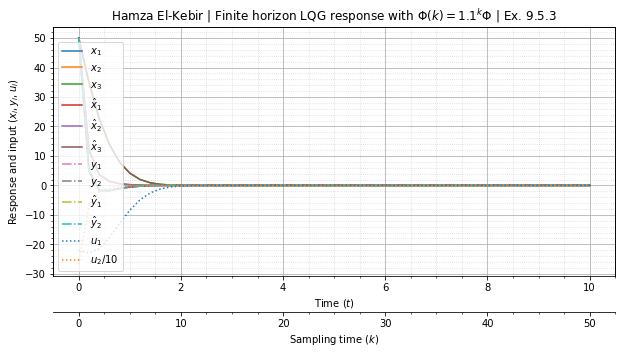

In [117]:
sysDT = DTLTI(Phi, Gamma, C, v_std=[0.0, 0.0])
sysDT.x0 = np.array([50,50,50])
sysDT.k = 0
sysDT.xbar0 = sysDT.x0
sysDT.xhat = sysDT.xbar0

x_lFH = [sysDT.x0]
x_lFH = [sysDT.x0]
xbar_lFH = [sysDT.xbar]
xhat_lFH = [sysDT.xhat]
y_lFH = [sysDT.y]

Phi_fn = lambda k : (1.1**k)*Phi

K = sysDT.LQR(Q1, Q2, N=50, Phi=Phi_fn, horizon="finite")
L = sysDT.LQE(Rw, Rv, N=50, x0=sysDT.xbar, Phi=Phi_fn, horizon="finite")

# sysDT.noise_measurement_std = [0.0002, 0.0001]

for k in range(50):
    sysDT.step(K=K[k], L=L[k], Phi=Phi_fn)
    x_lFH.append(sysDT.x)
    xbar_lFH.append(sysDT.xbar)
    xhat_lFH.append(sysDT.xhat)
    y_lFH.append(sysDT.y)
    
ax1 = plt.subplot(1,1,1)
    
ax1.plot(0.2*np.arange(0,50+0.2), [x[0] for x in x_lFH], label=r"$x_1$")
ax1.plot(0.2*np.arange(0,50+0.2), [x[1] for x in x_lFH], label=r"$x_2$")
ax1.plot(0.2*np.arange(0,50+0.2), [x[2] for x in x_lFH], label=r"$x_3$")
ax1.plot(0.2*np.arange(0,50+0.2), [x[0] for x in xhat_lFH], label=r"$\hat{x}_1$")
ax1.plot(0.2*np.arange(0,50+0.2), [x[1] for x in xhat_lFH], label=r"$\hat{x}_2$")
ax1.plot(0.2*np.arange(0,50+0.2), [x[2] for x in xhat_lFH], label=r"$\hat{x}_3$")
ax1.plot(0.2*np.arange(0,50+0.2), [y[0] for y in y_lFH], linestyle='-.', label=r"$y_1$")
ax1.plot(0.2*np.arange(0,50+0.2), [y[1] for y in y_lFH], linestyle='-.', label=r"$y_2$")
ax1.plot(0.2*np.arange(0,50+0.2), [C.dot(x)[0] for x in xhat_lFH], linestyle='-.', label=r"$\hat{y}_1$")
ax1.plot(0.2*np.arange(0,50+0.2), [C.dot(x)[0] for x in xhat_lFH], linestyle='-.', label=r"$\hat{y}_2$")
ax1.plot(0.2*np.arange(0,50+0.2), [(-K[k].dot(x))[0] for k, x in enumerate(x_lFH)], linestyle=':', label=r"$u_1$")
ax1.plot(0.2*np.arange(0,50+0.2), [(-K[k].dot(x))[1]/10 for k, x in enumerate(x_lFH)], linestyle=':', label=r"$u_2 / 10$")
ax1.set_xlabel(f"Time ($t$)")
ax1.set_ylabel(f"Response and input ($x_i, y_i, u_i$)")
ax1.minorticks_on()
ax1.grid(which='minor', alpha=0.5, linestyle=":")
ax1.grid(which='major')

plt.legend()

ax2 = ax1.twiny()
ax2.set_xticks(0.2*np.arange(0,51,10))
ax2.set_xticklabels(np.arange(0,51,10))
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 36))
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel(f"Sampling time ($k$)")
ax2.minorticks_on()

plt.tight_layout(2)
# plt.legend()
plt.title(r"Hamza El-Kebir | Finite horizon LQG response with $\Phi(k) = 1.1^k \Phi$ | Ex. 9.5.3")
plt.savefig("FinHor953LQG.pdf")

## Receding Horizon
### LQR

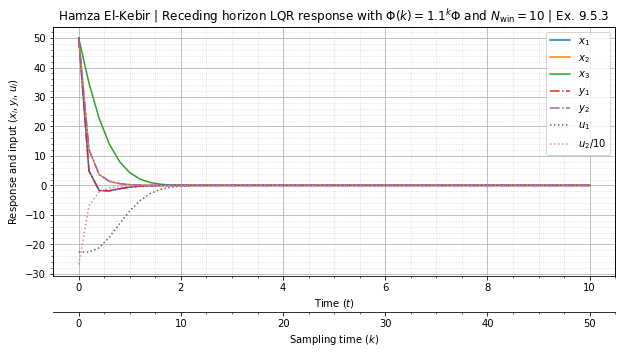

In [67]:
sysDT = DTLTI(Phi, Gamma, C)
sysDT.x0 = np.array([50,50,50])
sysDT.k = 0

Phi_fn = lambda k : (1.1**k)*Phi
# xN = lambda k : np.array([0,0,0,0]).reshape((4,1))

K = sysDT.LQR(Q1, Q2, Nwin=10, N=50, Phi=Phi_fn, horizon="receding")
K.append(np.zeros((sysDT.Gamma.shape[1], sysDT.Phi.shape[1])))

x_lRH = [sysDT.x0]
y_lRH = [sysDT.y]
    
for k in range(50):
    sysDT.step(K=K[k], Phi=Phi_fn)
    x_lRH.append(sysDT.x)
    y_lRH.append(sysDT.y)
    
ax1 = plt.subplot(1,1,1)
    
ax1.plot(0.2*np.arange(0,50+0.2), [x[0] for x in x_lRH], label=r"$x_1$")
ax1.plot(0.2*np.arange(0,50+0.2), [x[1] for x in x_lRH], label=r"$x_2$")
ax1.plot(0.2*np.arange(0,50+0.2), [x[2] for x in x_lRH], label=r"$x_3$")
ax1.plot(0.2*np.arange(0,50+0.2), [y[0] for y in y_lRH], linestyle='-.', label=r"$y_1$")
ax1.plot(0.2*np.arange(0,50+0.2), [y[1] for y in y_lRH], linestyle='-.', label=r"$y_2$")
ax1.plot(0.2*np.arange(0,50+0.2), [(-K[k].dot(x))[0] for k, x in enumerate(x_lRH)], linestyle=':', label=r"$u_1$")
ax1.plot(0.2*np.arange(0,50+0.2), [(-K[k].dot(x))[1]/10 for k, x in enumerate(x_lRH)], linestyle=':', label=r"$u_2 / 10$")
# plt.yscale("symlog")
ax1.set_xlabel(f"Time ($t$)")
ax1.set_ylabel(f"Response and input ($x_i, y_i, u_i$)")
ax1.minorticks_on()
ax1.grid(which='minor', alpha=0.5, linestyle=":")
ax1.grid(which='major')

plt.legend()

ax2 = ax1.twiny()
ax2.set_xticks(0.2*np.arange(0,51,10))
ax2.set_xticklabels(np.arange(0,51,10))
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 36))
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel(f"Sampling time ($k$)")
ax2.minorticks_on()
    
plt.tight_layout(2)
plt.title(r"Hamza El-Kebir | Receding horizon LQR response with $\Phi(k) = 1.1^k \Phi$ and $N_\mathrm{win} = 10$ | Ex. 9.5.3")
plt.savefig("MovHor953.pdf")

### LQG

/usr/local/lib/python3.7/site-packages/numpy/linalg/linalg.py:1974: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff


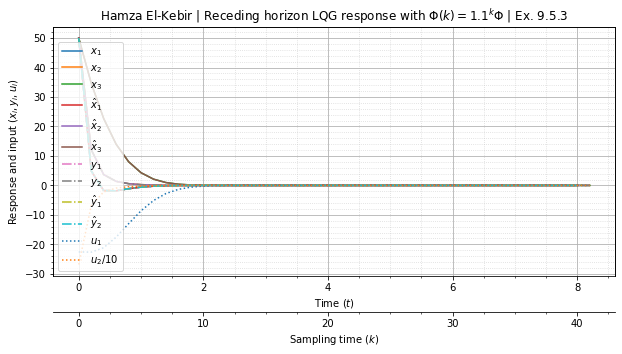

In [115]:
sysDT = DTLTI(Phi, Gamma, C, v_std=[0,0])
sysDT.x0 = np.array([50,50,50])
sysDT.k = 0
sysDT.xbar0 = sysDT.x0
sysDT.xhat = sysDT.xbar0

x_lRH = [sysDT.x0]
x_lRH = [sysDT.x0]
xbar_lRH = [sysDT.xbar]
xhat_lRH = [sysDT.xhat]
y_lRH = [sysDT.y]

Phi_fn = lambda k : (1.1**k)*Phi

K = sysDT.LQR(Q1, Q2, N=50, Nwin=10, Phi=Phi_fn, horizon="moving")
K.append(np.zeros((sysDT.Gamma.shape[1], sysDT.Phi.shape[1])))

L = sysDT.LQE(Rw, Rv, N=50, Nwin=10, x0=sysDT.xbar, Phi=Phi_fn, horizon="moving")

# sysDT.noise_measurement_std = [2e-5,1e-5]

for k in range(50):
    sysDT.step(K=K[k], L=L[k], Phi=Phi_fn)
    x_lRH.append(sysDT.x)
    xbar_lRH.append(sysDT.xbar)
    xhat_lRH.append(sysDT.xhat)
    y_lRH.append(sysDT.y)
    
ax1 = plt.subplot(1,1,1)
    
ax1.plot(0.2*np.arange(0,50+0.2), [x[0] for x in x_lRH], label=r"$x_1$")
ax1.plot(0.2*np.arange(0,50+0.2), [x[1] for x in x_lRH], label=r"$x_2$")
ax1.plot(0.2*np.arange(0,50+0.2), [x[2] for x in x_lRH], label=r"$x_3$")
ax1.plot(0.2*np.arange(0,50+0.2), [x[0] for x in xhat_lRH], label=r"$\hat{x}_1$")
ax1.plot(0.2*np.arange(0,50+0.2), [x[1] for x in xhat_lRH], label=r"$\hat{x}_2$")
ax1.plot(0.2*np.arange(0,50+0.2), [x[2] for x in xhat_lRH], label=r"$\hat{x}_3$")
ax1.plot(0.2*np.arange(0,50+0.2), [y[0] for y in y_lRH], linestyle='-.', label=r"$y_1$")
ax1.plot(0.2*np.arange(0,50+0.2), [y[1] for y in y_lRH], linestyle='-.', label=r"$y_2$")
ax1.plot(0.2*np.arange(0,50+0.2), [C.dot(x)[0] for x in xhat_lRH], linestyle='-.', label=r"$\hat{y}_1$")
ax1.plot(0.2*np.arange(0,50+0.2), [C.dot(x)[0] for x in xhat_lRH], linestyle='-.', label=r"$\hat{y}_2$")
ax1.plot(0.2*np.arange(0,50+0.2), [(-K[k].dot(x))[0] for k, x in enumerate(x_lRH)], linestyle=':', label=r"$u_1$")
ax1.plot(0.2*np.arange(0,50+0.2), [(-K[k].dot(x))[1]/10 for k, x in enumerate(x_lRH)], linestyle=':', label=r"$u_2 / 10$")
ax1.set_xlabel(f"Time ($t$)")
ax1.set_ylabel(f"Response and input ($x_i, y_i, u_i$)")
ax1.minorticks_on()
ax1.grid(which='minor', alpha=0.5, linestyle=":")
ax1.grid(which='major')

plt.legend()

ax2 = ax1.twiny()
ax2.set_xticks(0.2*np.arange(0,51,10))
ax2.set_xticklabels(np.arange(0,51,10))
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 36))
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel(f"Sampling time ($k$)")
ax2.minorticks_on()

plt.tight_layout(2)
# plt.legend()
plt.title(r"Hamza El-Kebir | Receding horizon LQG response with $\Phi(k) = 1.1^k \Phi$ | Ex. 9.5.3")
plt.savefig("MovHor953LQG.pdf")

## Response Comparison
### LQR

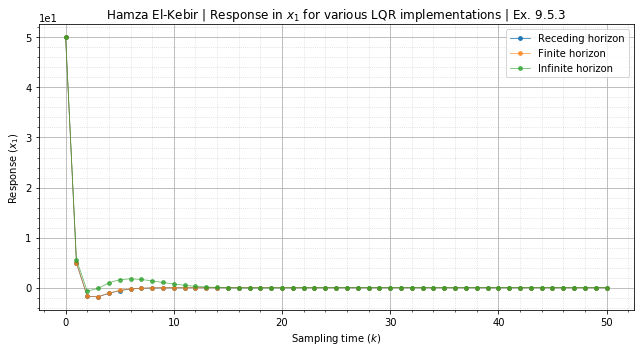

In [70]:
plt.plot([x[0] for x in x_lRH], marker='.', markersize=7.5, linewidth='.75', label='Receding horizon')
plt.plot([x[0] for x in x_lFH], marker='.', alpha=0.75, markersize=7.5, linewidth='.75', label='Finite horizon')
plt.plot([x[0] for x in x_lIH], marker='.', alpha=0.75, markersize=7.5, linewidth='.75', label='Infinite horizon')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.minorticks_on()
plt.grid(which='minor', alpha=0.5, linestyle=":")
plt.grid(which='major')
plt.xlabel(f"Sampling time ($k$)")
plt.ylabel(f"Response ($x_1$)")
plt.legend()
plt.title(r"Hamza El-Kebir | Response in $x_1$ for various LQR implementations | Ex. 9.5.3")
plt.tight_layout()
plt.savefig("x1RespIF953.pdf")

### LQG

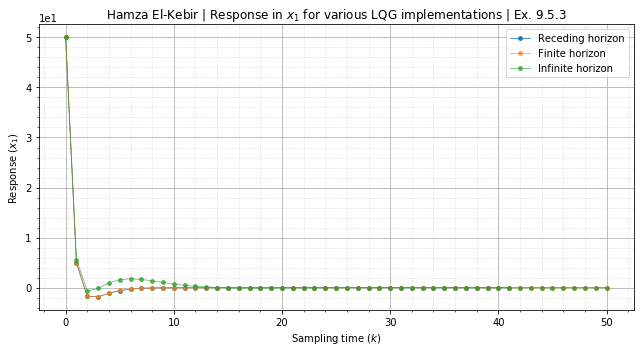

In [118]:
plt.plot([x[0] for x in x_lRH], marker='.', markersize=7.5, linewidth='.75', label='Receding horizon')
plt.plot([x[0] for x in x_lFH], marker='.', alpha=0.75, markersize=7.5, linewidth='.75', label='Finite horizon')
plt.plot([x[0] for x in x_lIH], marker='.', alpha=0.75, markersize=7.5, linewidth='.75', label='Infinite horizon')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.minorticks_on()
plt.grid(which='minor', alpha=0.5, linestyle=":")
plt.grid(which='major')
plt.xlabel(f"Sampling time ($k$)")
plt.ylabel(f"Response ($x_1$)")
plt.legend()
plt.title(r"Hamza El-Kebir | Response in $x_1$ for various LQG implementations | Ex. 9.5.3")
plt.tight_layout()
plt.savefig("x1RespIF953LQG.pdf")